# Import Library

In [1]:
import ccxt
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np

# Initialize Config

In [3]:
binance = ccxt.binance()
symbol = 'BTC/USDT'
timeframe = '1m'  

# Data Processing

## Fetch Data

In [16]:
# ohlcv = binance.fetch_ohlcv(symbol, timeframe)
since_timestamp = 1700510400000
until_timestamp = 1702481582000

limit = 1000
ohlcv = []

while since_timestamp < until_timestamp:
    ohlcv_part = binance.fetch_ohlcv(symbol, timeframe, since=since_timestamp, limit=limit)
    if not ohlcv_part:
        break
    ohlcv.extend(ohlcv_part)
    since_timestamp = ohlcv_part[-1][0] + 1

## Convert to Dataframe

In [18]:
df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms') 
df.set_index('timestamp', inplace=True)

# Stationarity Check

In [20]:
def Stationarity_check(data):
    result = adfuller(data.dropna(), autolag='AIC')
    print('\nAugmented Dickey-Fuller Test Results:')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical Values: {result[4]}')
    print('\nThe data is Stationary.') if result[1] <= 0.05 else print('\nThe data is not Stationary.')

In [21]:
Stationarity_check(df["close"])


Augmented Dickey-Fuller Test Results:
ADF Statistic: -0.8353983546568695
p-value: 0.8085023386926349
Critical Values: {'1%': -3.4305491355684365, '5%': -2.8616280128181644, '10%': -2.566816846488637}

The data is not Stationary.


# Alternative Ways

## Differencing

difference of the series by subtracting the previous value from the current one.

In [22]:
df['close_diff'] = df['close'].diff()

In [23]:
Stationarity_check(df["close_diff"])


Augmented Dickey-Fuller Test Results:
ADF Statistic: -28.369896539679065
p-value: 0.0
Critical Values: {'1%': -3.4305491355684365, '5%': -2.8616280128181644, '10%': -2.566816846488637}

The data is Stationary.


## Log Transformation

Apply a log transformation to stabilize variance.

In [24]:
df['close_log'] = df['close'].apply(lambda x: np.log(x))

In [25]:
Stationarity_check(df["close_diff"])


Augmented Dickey-Fuller Test Results:
ADF Statistic: -28.369896539679065
p-value: 0.0
Critical Values: {'1%': -3.4305491355684365, '5%': -2.8616280128181644, '10%': -2.566816846488637}

The data is Stationary.


## Moving Average

In [26]:
average_bar = 24
df['close_ma'] = df['close'].rolling(window=average_bar).mean()

In [27]:
Stationarity_check(df["close_ma"])


Augmented Dickey-Fuller Test Results:
ADF Statistic: -0.9641294541232599
p-value: 0.7661214730076331
Critical Values: {'1%': -3.4305493298089456, '5%': -2.861628098664609, '10%': -2.566816892182534}

The data is not Stationary.


# Plot Setup

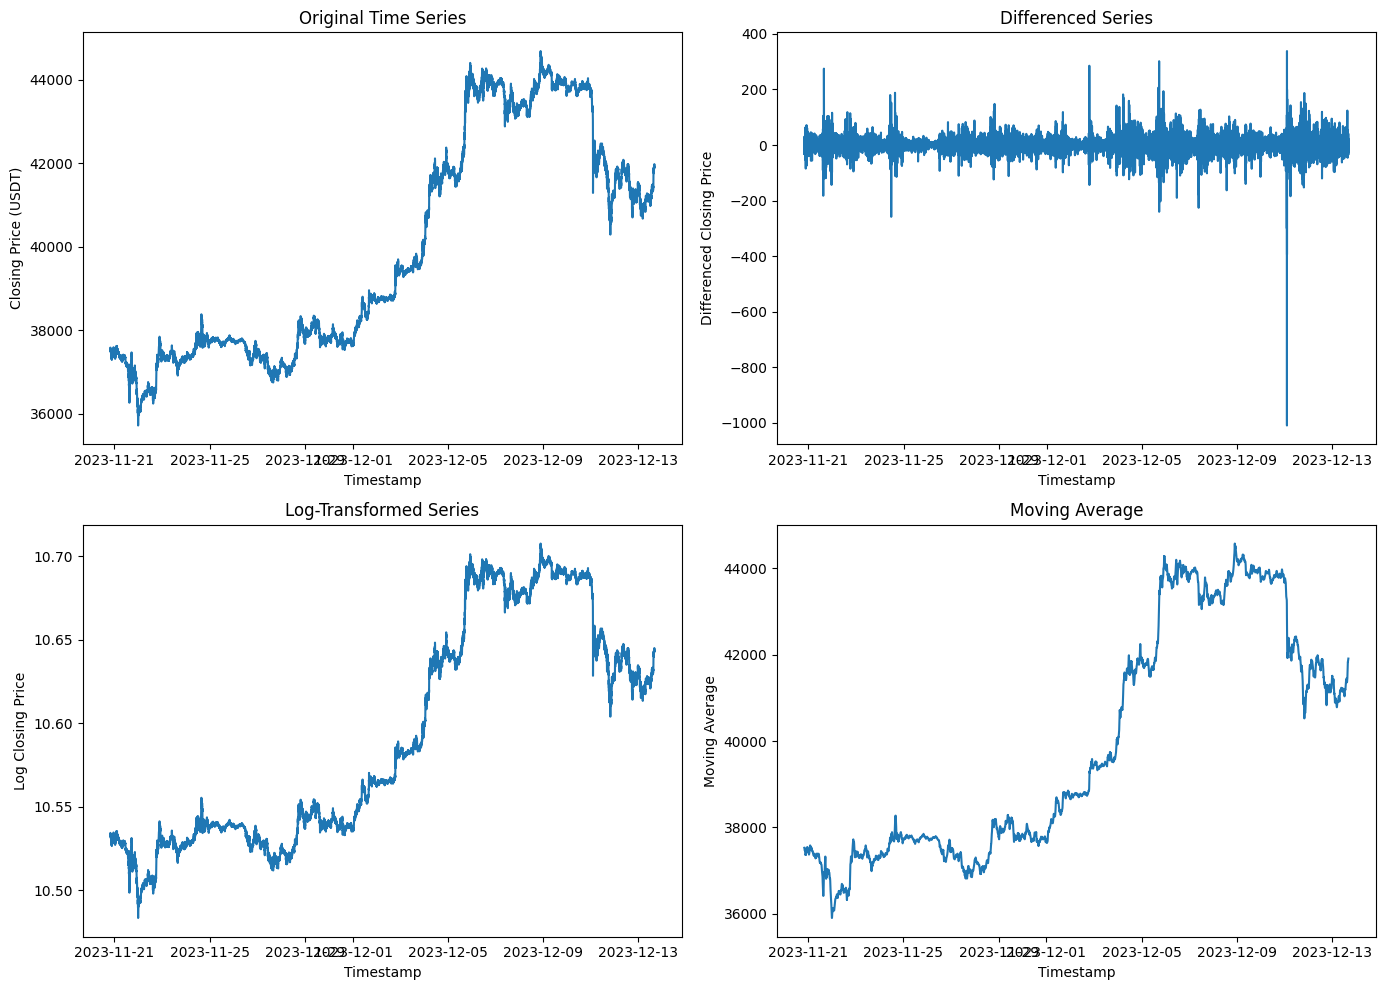

In [28]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

# Original Time Series
axes[0, 0].plot(df['close'])
axes[0, 0].set_title('Original Time Series')
axes[0, 0].set_xlabel('Timestamp')
axes[0, 0].set_ylabel('Closing Price (USDT)')

# Differenced Series
axes[0, 1].plot(df['close_diff'])
axes[0, 1].set_title('Differenced Series')
axes[0, 1].set_xlabel('Timestamp')
axes[0, 1].set_ylabel('Differenced Closing Price')

# Log-Transformed Series
axes[1, 0].plot(df['close_log'])
axes[1, 0].set_title('Log-Transformed Series')
axes[1, 0].set_xlabel('Timestamp')
axes[1, 0].set_ylabel('Log Closing Price')

# Moving Average
axes[1, 1].plot(df['close_ma'])
axes[1, 1].set_title('Moving Average')
axes[1, 1].set_xlabel('Timestamp')
axes[1, 1].set_ylabel('Moving Average')

plt.tight_layout()
plt.show()